**Toxic comment classification LSTM**

Character-level and word-level RNN  
Genereally, word-level is better as it has to make less predictions, hence, less error prone  
Also, also its easier to train than characeter-level (Cross entropy loss)

Loss function: Not accuracy (coz, the data is highly imbalanced)
Use: Hamming loss, log loss

CNN vs RNN  
depends on how much of a task is dependent. If the length is imp, eg: QnAs, translation. . GO WITH RNN  
Else, if feature dedtction in text is more imp, eg: angry, sad, abuses. .  GO FOR CNN

In [1]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [2]:
from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


In [3]:
MAX_NB_WORDS = 200000    # max words for tokenizer
MAX_SEQUENCE_LENGTH = 400 # max length sentence including pads, we chose this len because it will cover 80% of data 
VALIDATION_SPLIT = 0.2   
EMBEDDING_DIM = 200     
GLOVE_DIR = "glove.6B/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [4]:
import pandas as pd
data = pd.read_csv('data/train.csv')

In [5]:
data.shape

(159571, 8)

In [6]:
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [7]:
num_test_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_test_samples]
y_train = labels[: -num_test_samples]
x_test = data[-num_test_samples: ]
y_test = labels[-num_test_samples: ]

In [8]:
y_train.shape, y_test.shape

((127657, 6), (31914, 6))

In [9]:
X_train = x_train['comment_text']
X_test = x_test['comment_text'] 

In [10]:
y_train.shape

(127657, 6)

#### counting how many words are there in each type of toxic comment 


In [11]:
print('each count in train: ', y_train.sum(axis=0))

print('each count in test: ', y_test.sum(axis=0))


each count in train:  [12257  1284  6780   386  6295  1100]
each count in test:  [3037  311 1669   92 1582  305]


### removing stop words, punctuations, making lowercase

In [12]:
X_train = X_train.apply(lambda x: x.strip().lower())
X_train = X_train.apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

stopWords = set(stopwords.words('english'))
def remove_stopwords(line):
    clean_words = [word for word in line.split() if word not in stopWords]
    return ' '.join(clean_words)
X_train = X_train.apply(remove_stopwords)

In [13]:
X_test = X_test.apply(lambda x: x.strip().lower())
X_test = X_test.apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

stopWords = set(stopwords.words('english'))
def remove_stopwords(line):
    clean_words = [word for word in line.split() if word not in stopWords]
    return ' '.join(clean_words)
X_test = X_test.apply(remove_stopwords)

In [14]:
X_train, X_test

(0         explanation edits made username hardcore metal...
 1         daww matches background colour im seemingly st...
 2         hey man im really trying edit war guy constant...
 3         cant make real suggestions improvement wondere...
 4                       sir hero chance remember page thats
                                 ...                        
 127652                                             well see
 127653    speedy deletion 27 tricor ave new paltz ny 125...
 127654    additions made 100 factual apparent youre anot...
 127655    nathan thousand times seems let try explain ar...
 127656    march 2007 utc imagemarist high school oregon ...
 Name: comment_text, Length: 127657, dtype: object,
 127657    notice changed username accordance wiki polici...
 127658    wp articles genealogical entries trees says wp...
 127659                  redirect talkjohn rogers footballer
 127660    nfl draft batch copyandpasting draft order tim...
 127661    discussion copied wp r

### Finding avg length avg length and total length distribution 

In [15]:
X_train.shape

(127657,)

In [16]:
import matplotlib.pyplot as plt

average length of comment: 255.071


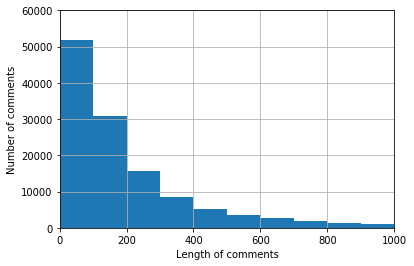

In [17]:

x = [len(X_train[i]) for i in range(X_train.shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1,100,200,300,400,500,600,700,800,900,1000]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1000, 0, 60000])
plt.grid(True)
plt.show()

In [18]:
lemmatiser = WordNetLemmatizer()
stemmer = PorterStemmer()
#download words from wordnet library
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/aj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
"""for i in range(len(X_train)):
    l = []
    for word in X_train[i].split():
        l.append(stemmer.stem(lemmatiser.lemmatize(word,pos="v")))
    X_train[i] = " ".join(l)"""

'for i in range(len(X_train)):\n    l = []\n    for word in X_train[i].split():\n        l.append(stemmer.stem(lemmatiser.lemmatize(word,pos="v")))\n    X_train[i] = " ".join(l)'

In [20]:
print('Sample data:', X_train[1], y_train[1])

Sample data: daww matches background colour im seemingly stuck thanks talk 2151 january 11 2016 utc [0 0 0 0 0 0]


**oov_token** (if it ever sees a new word)  
### tokenizing

In [21]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token = True)
tokenizer.fit_on_texts(X_train)

In [22]:
sequences = tokenizer.texts_to_sequences(X_train)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 213981


In [23]:
sequences2 = tokenizer.texts_to_sequences(X_test)
word_index2 = tokenizer.word_index
print('Vocabulary size:', len(word_index2))

Vocabulary size: 213981


In [24]:
sequences[0]

[517,
 44,
 48,
 512,
 4356,
 12081,
 1155,
 212,
 1928,
 10536,
 6576,
 2517,
 2689,
 37,
 1021,
 14712,
 2651,
 6,
 10,
 137,
 309,
 5,
 3,
 59,
 14,
 3457,
 58446]

### padding and creating a tensor 

In [25]:

data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (127657, 400)
Shape of label tensor: (127657, 6)


In [26]:
data2 = pad_sequences(sequences2, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data2.shape)
print('Shape of label tensor:', y_test.shape)

Shape of data tensor: (31914, 400)
Shape of label tensor: (31914, 6)


In [27]:
import numpy as np
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
y_train = y_train[indices]

In [28]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = y_train[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = y_train[-num_validation_samples: ]

In [29]:
x_train.shape, x_val.shape

((102126, 400), (25531, 400))

In [30]:

print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [9778 1012 5399  315 5015  859]
validation:  [2422  240 1342   72 1260  203]


In [31]:
print('Tokenized sentences: \n', x_train[0])
print('One hot label: \n', y_train[0])

Tokenized sentences: 
 [  236   131   841 10855 15826     2     1   707  1337   115  1525   180
   159   141     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [32]:
import numpy as np

### word embedding gLoVe

In [33]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove.6B/glove.6B.200d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [34]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

making Sequential neural network using **Model()** API

In [35]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

In [36]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embeddings (Embedding)       (None, 400, 200)          42796400  
_________________________________________________________________
lstm_layer (LSTM)            (None, 400, 60)           62640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

In [37]:
import timeit 

In [38]:
start_time = timeit.default_timer()

print('Training progress:')
history = model.fit(x_train, y_train, epochs = 1, batch_size=32, validation_data=(x_val, y_val))

elapsed_pa = timeit.default_timer() - start_time


Training progress:
Train on 102126 samples, validate on 25531 samples
Epoch 1/1
102126/102126 [==============================] - 757s 7ms/step - loss: 0.0677 - accuracy: 0.9771 - val_loss: 0.3037 - val_accuracy: 0.9376


In [39]:
print(elapsed_pa)

758.1829658429999


In [40]:
predict = model.predict(data2)

In [41]:
predict.shape

(31914, 6)

In [42]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score

### loss and score

In [43]:

predict = np.round(predict)
loss = hamming_loss(y_test,predict)
print("Hamming_loss : {}".format(loss*100))
accuracy = accuracy_score(y_test,predict)
print("Accuracy : {}".format(accuracy*100))

Hamming_loss : 1.9390654049424496
Accuracy : 91.55543021871279


#### Lets **try** with sentences

In [44]:
first = tokenizer.texts_to_sequences(["you fucking moron", "i love you"])
dataf = pad_sequences(first, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

In [45]:
dataf.shape

(2, 400)

In [46]:
predictf = model.predict(dataf)

In [47]:
predictf.shape

(2, 6)

In [48]:

print('toxic'+ ' '+ 'severe_toxic'+ ' ' +'obscene'+' '+ 'threat'+' '+'insult'+' '+'identity_hate')
print(predictf> 0.5)


toxic severe_toxic obscene threat insult identity_hate
[[ True False  True False  True False]
 [False False False False False False]]


In [53]:
filename = 'LSTM.h5'

In [54]:
model.save(filename)

**LOAD MODEL AGAIN FOR USE, IF**

In [1]:
from keras.models import load_model

Using TensorFlow backend.


In [2]:
filename = 'LSTM.h5'

In [3]:
model = load_model(filename)

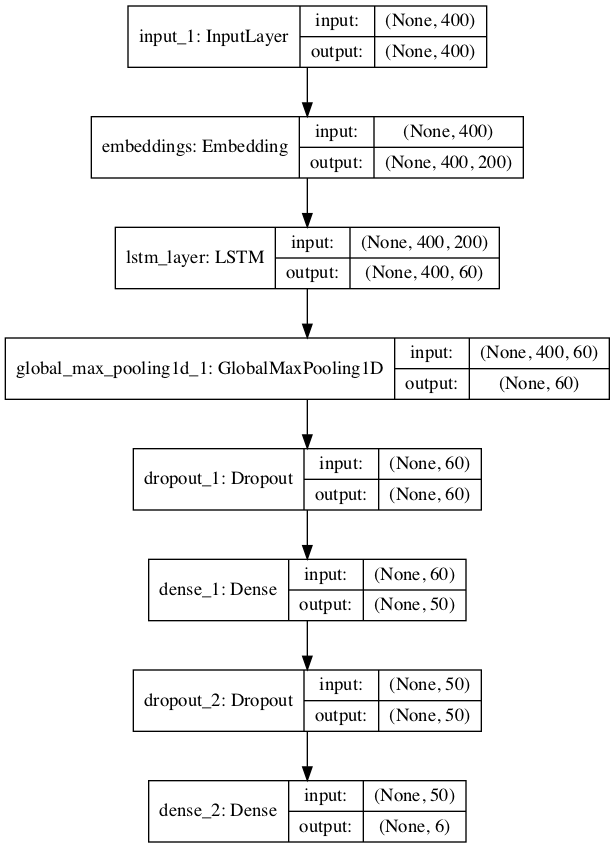

In [5]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, to_file='model_graph.png')